In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import os
from pathlib import Path
import json
import collections
from src.visualize import filter_path_1, filter_path_2, get_scores, get_scores_json, plot_scores, calculate_average_ranking, calculate_average_score

In [2]:
base_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/BIGBENCH"
results_one_shot_path = os.path.join(base_path, "results.json")
results_few_shot_path = os.path.join(base_path, "results_few-shot.json")

with open(results_one_shot_path) as f:
    results_one_shot = json.load(f)

with open(results_few_shot_path) as f:
    results_few_shot = json.load(f)

metrics = {}

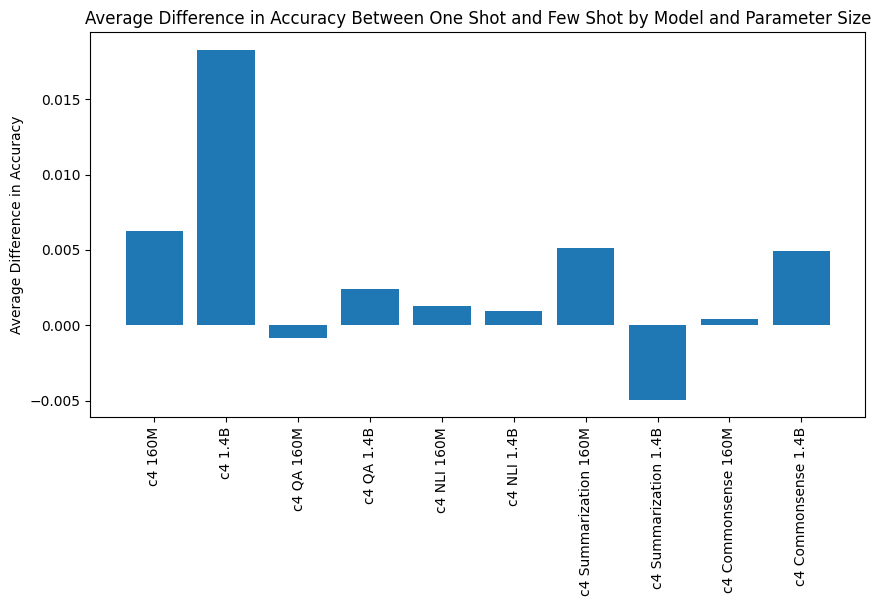

In [22]:
c4_only = ['c4']
# c4_supervised = [model for model in avg_diff_dict_base_model.keys() if model not in c4_only]
c4_supervised = ['c4 Commonsense']

# Create dictionaries to store total differences, sum of squares of differences, and counts for each model
diff_dict = collections.defaultdict(float)
diff_dict_dataset = collections.defaultdict(float)
sum_of_squares_dict = collections.defaultdict(float)
count_dict = collections.defaultdict(int)
diff_dict_group = collections.defaultdict(lambda: collections.defaultdict(list))

metric = 'multiple_choice_grade'
metric_std = 'multiple_choice_grade_stderr'

# Iterate over datasets in results_one_shot
for dataset in results_one_shot:
    # Check if the dataset also exists in results_few_shot
    if dataset in results_few_shot:
        # Iterate over models in the dataset
        for model in results_one_shot[dataset]:
            # Check if the model also exists in results_few_shot for the same dataset
            if model in results_few_shot[dataset]:
                # Iterate over parameter sizes in the model
                for param_size in results_one_shot[dataset][model]:
                    # Check if the parameter size also exists in results_few_shot for the same dataset and model
                    if param_size in results_few_shot[dataset][model]:
                        # Get the 'acc' from both dictionaries
                        acc_one_shot = results_one_shot[dataset][model][param_size][metric]
                        acc_few_shot = results_few_shot[dataset][model][param_size][metric]
                        
                        # Calculate the difference and store it
                        diff = acc_few_shot - acc_one_shot
                        model_param_size = f"{model} {param_size}"
                        diff_dict[model_param_size] += diff
                        diff_dict_dataset[dataset] += diff
                        sum_of_squares_dict[model_param_size] += diff ** 2
                        count_dict[model_param_size] += 1
                        group = 'c4_only' if model in c4_only else 'c4_supervised'
                        diff_dict_group[dataset][group].append(diff)

# Calculate average difference and standard deviation for each model
avg_diff_dict = {model: diff_dict[model] / count_dict[model] for model in diff_dict}
std_diff_dict = {model: ((sum_of_squares_dict[model] / count_dict[model]) - (avg_diff_dict[model] ** 2)) ** 0.5 for model in diff_dict}
avg_diff_dict_dataset = {dataset: np.mean(diff_dict_dataset[dataset]) for dataset in diff_dict_dataset}
std_diff_dict_dataset = {dataset: np.std(diff_dict_dataset[dataset]) for dataset in diff_dict_dataset}
avg_diff_dict_group = {dataset: {group: np.mean(diff_dict_group[dataset][group]) for group in diff_dict_group[dataset]} for dataset in diff_dict_group}


MODEL_ORDER = ["c4 160M", "c4 1.4B", "c4 QA 160M", "c4 QA 1.4B", "c4 NLI 160M", "c4 NLI 1.4B", 
               "c4 Summarization 160M", "c4 Summarization 1.4B", "c4 Commonsense 160M", "c4 Commonsense 1.4B"]
avg_diff_dict = {k: avg_diff_dict[k] for k in MODEL_ORDER}
std_diff_dict = {k: std_diff_dict[k] for k in MODEL_ORDER}

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(avg_diff_dict.keys(), avg_diff_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Average Difference in Accuracy')
plt.title('Average Difference in Accuracy Between One Shot and Few Shot by Model and Parameter Size')
plt.show()

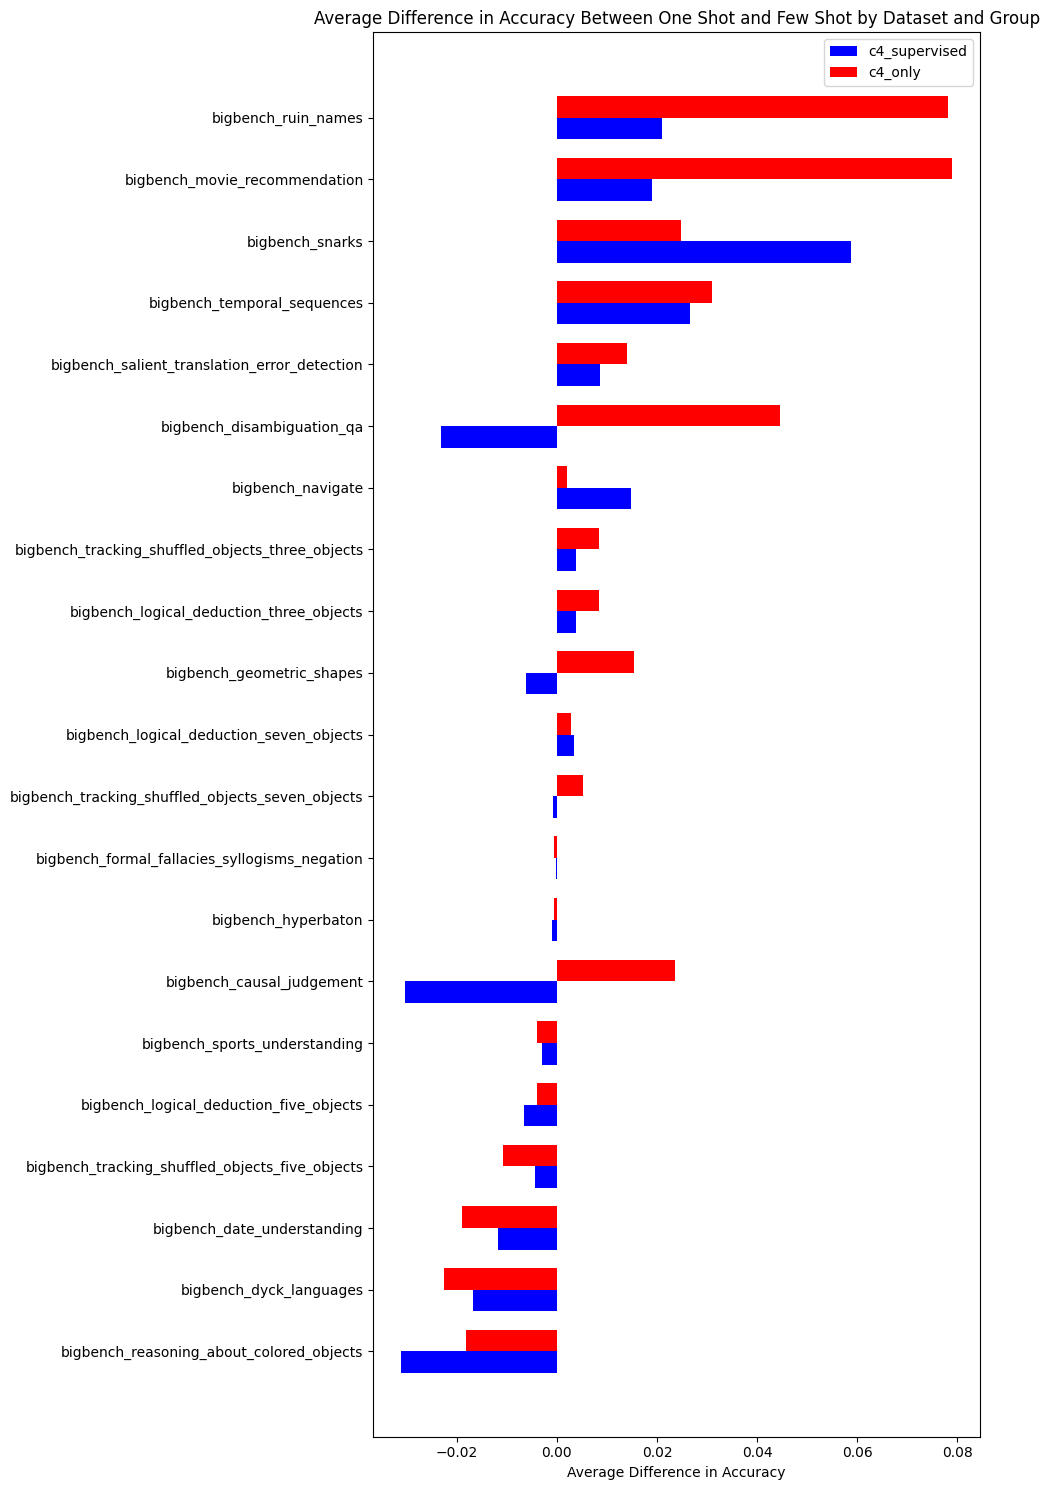

In [23]:
# Define the colors for the two groups
colors = {'c4_supervised': 'b', 'c4_only': 'r'}

# Calculate the average differences for each dataset and group
avg_diff_dict_group = {dataset: {group: np.mean(diff_dict_group[dataset][group]) for group in diff_dict_group[dataset]} for dataset in diff_dict_group}

# choose only 

# Sort the datasets by average difference
datasets_sorted = sorted(avg_diff_dict_group.items(), key=lambda x: np.mean(list(x[1].values())))

# Get the sorted datasets and their average differences
datasets, avg_diffs_group = zip(*datasets_sorted)

# Create a horizontal bar chart
plt.figure(figsize=(10, 15))

# Define the width of a bar
bar_width = 0.35

# Define the y locations for the groups
y = np.arange(len(datasets))

# Create the bars for each group
for i, dataset in enumerate(datasets):
    for j, (group, avg_diff) in enumerate(avg_diffs_group[i].items()):
        plt.barh(y[i] + j*bar_width, avg_diff, height=bar_width, color=colors[group])

plt.yticks(y + bar_width / 2, datasets)
plt.xlabel('Average Difference in Accuracy')
plt.title('Average Difference in Accuracy Between One Shot and Few Shot by Dataset and Group')
plt.legend(['c4_supervised', 'c4_only'])

plt.tight_layout()
plt.show()

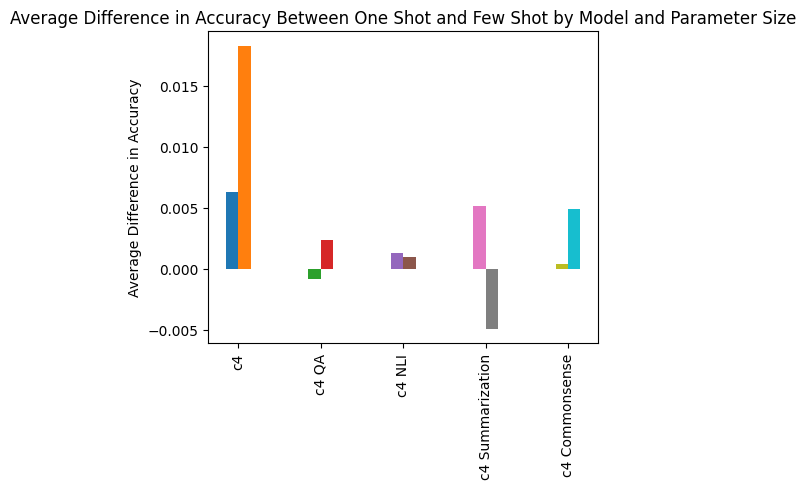

In [12]:
# Create dictionaries to store total differences, sum of squares of differences, and counts for each base model
diff_dict_base_model = collections.defaultdict(list)
sum_of_squares_dict_base_model = collections.defaultdict(list)
count_dict_base_model = collections.defaultdict(int)

# Iterate over avg_diff_dict
for model, diff in avg_diff_dict.items():
    # Split the model into base model and param size
    base_model, param_size = model.rsplit(' ', 1)
    # Append the model and its difference to the list of the corresponding base model
    diff_dict_base_model[base_model].append((model, diff))
    sum_of_squares_dict_base_model[base_model].append((model, diff ** 2))
    count_dict_base_model[base_model] += 1

# Calculate average difference and standard deviation for each base model
avg_diff_dict_base_model = {base_model: sum(diff for model, diff in diffs) / count_dict_base_model[base_model] for base_model, diffs in diff_dict_base_model.items()}
std_diff_dict_base_model = {base_model: ((sum(diff for model, diff in sum_of_squares_dict_base_model[base_model]) / count_dict_base_model[base_model]) - (avg_diff_dict_base_model[base_model] ** 2)) ** 0.5 for base_model in diff_dict_base_model}

# Create a grouped bar plot
plt.figure(figsize=(5, 5))

# Define the width of a bar
bar_width = 0.15

# Define the x locations for the groups
x = np.arange(len(diff_dict_base_model.keys()))

# For each base model, create a group of bars
for i, (base_model, diffs) in enumerate(diff_dict_base_model.items()):
    # Sort the diffs by MODEL_ORDER
    diffs = sorted(diffs, key=lambda x: MODEL_ORDER.index(x[0]))
    # Get the models and their differences
    models, diffs = zip(*diffs)
    # Create the bars for this group
    for j, model in enumerate(models):
        plt.bar(x[i] + j*bar_width, diffs[j], width=bar_width, label=model)

plt.xticks(x + bar_width / 2, diff_dict_base_model.keys(), rotation=90)
plt.ylabel('Average Difference in Accuracy')
plt.title('Average Difference in Accuracy Between One Shot and Few Shot by Model and Parameter Size')
# plt.legend()

plt.tight_layout()
plt.show()

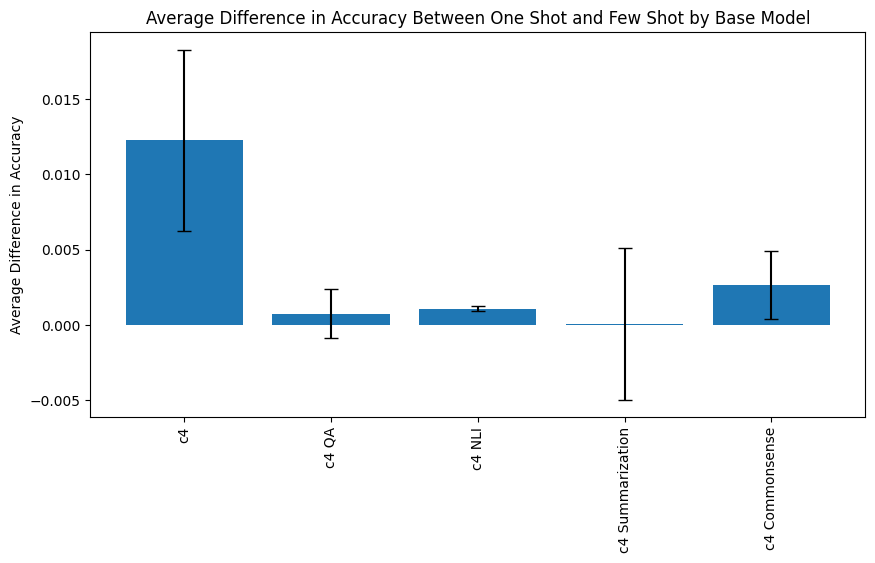

In [13]:
# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(avg_diff_dict_base_model.keys(), avg_diff_dict_base_model.values(), yerr=[std_diff_dict_base_model[model] for model in avg_diff_dict_base_model.keys()], capsize=5)
plt.xticks(rotation=90)
plt.ylabel('Average Difference in Accuracy')
plt.title('Average Difference in Accuracy Between One Shot and Few Shot by Base Model')
plt.show()


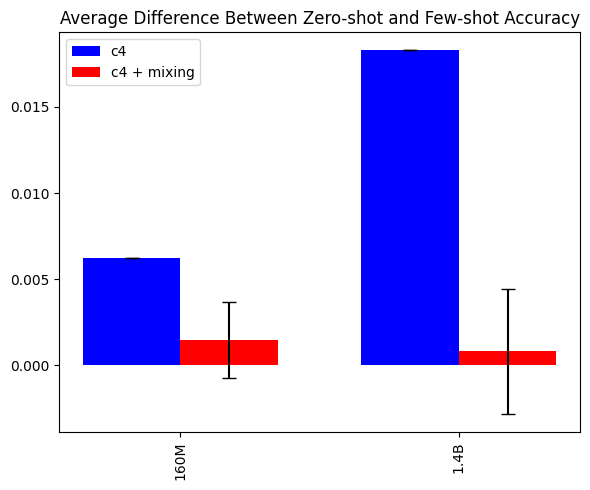

In [14]:
c4_only = ['c4']
c4_supervised = [model for model in avg_diff_dict_base_model.keys() if model not in c4_only]

# Create dictionaries to store total differences, sum of squares of differences, and counts for each group and parameter size
total_diff_c4_only = collections.defaultdict(float)
total_diff_c4_supervised = collections.defaultdict(float)
sum_of_squares_c4_only = collections.defaultdict(float)
sum_of_squares_c4_supervised = collections.defaultdict(float)
count_c4_only = collections.defaultdict(int)
count_c4_supervised = collections.defaultdict(int)

# Iterate over base models in diff_dict_base_model
for base_model, model_diffs in diff_dict_base_model.items():
    for model, diff in model_diffs:
        # Split the model into base model and param size
        _, param_size = model.rsplit(' ', 1)
        # Check if the base model is in c4_only or c4_supervised
        if base_model in c4_only:
            total_diff_c4_only[param_size] += diff
            sum_of_squares_c4_only[param_size] += diff ** 2
            count_c4_only[param_size] += 1
        elif base_model in c4_supervised:
            total_diff_c4_supervised[param_size] += diff
            sum_of_squares_c4_supervised[param_size] += diff ** 2
            count_c4_supervised[param_size] += 1

# Calculate average differences and standard deviations for each parameter size in each group
avg_diff_c4_only = {param_size: total_diff_c4_only[param_size] / count_c4_only[param_size] for param_size in total_diff_c4_only}
avg_diff_c4_supervised = {param_size: total_diff_c4_supervised[param_size] / count_c4_supervised[param_size] for param_size in total_diff_c4_supervised}
std_diff_c4_only = {param_size: ((sum_of_squares_c4_only[param_size] / count_c4_only[param_size]) - (avg_diff_c4_only[param_size] ** 2)) ** 0.5 for param_size in total_diff_c4_only}
std_diff_c4_supervised = {param_size: ((sum_of_squares_c4_supervised[param_size] / count_c4_supervised[param_size]) - (avg_diff_c4_supervised[param_size] ** 2)) ** 0.5 for param_size in total_diff_c4_supervised}

# Plot the results
plt.figure(figsize=(6, 5))

# Define the width of a bar
bar_width = 0.35

# Define the x locations for the groups
x = np.arange(len(avg_diff_c4_only))

# Create the bars for c4_only
plt.bar(x - bar_width/2, avg_diff_c4_only.values(), width=bar_width, color='b', yerr=[std_diff_c4_only[param_size] for param_size in avg_diff_c4_only], capsize=5)
# Create the bars for c4_supervised
plt.bar(x + bar_width/2, avg_diff_c4_supervised.values(), width=bar_width, color='r', yerr=[std_diff_c4_supervised[param_size] for param_size in avg_diff_c4_supervised], capsize=5)

plt.xticks(x, avg_diff_c4_only.keys(), rotation=90)
plt.title('Average Difference Between Zero-shot and Few-shot Accuracy')
plt.legend(['c4', 'c4 + mixing'], loc='upper left')

plt.tight_layout()
plt.show()

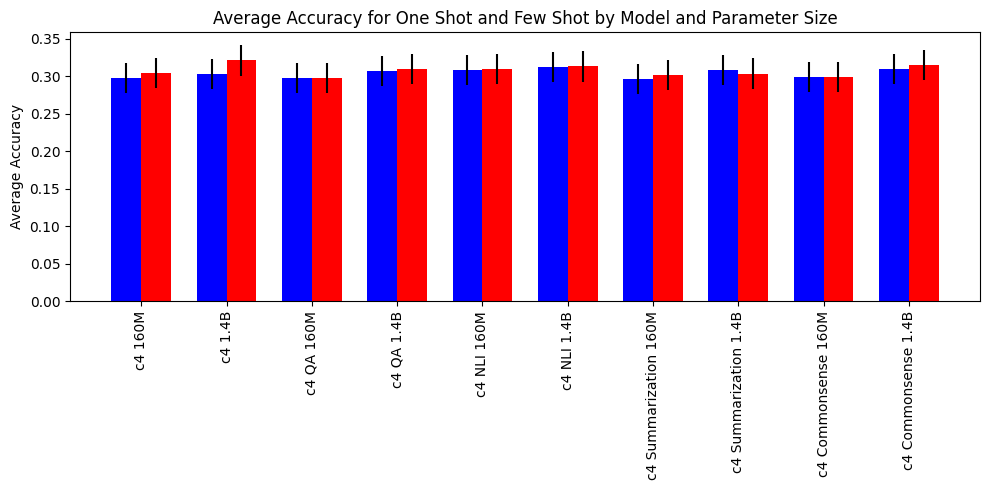

In [15]:
# Create dictionaries to store total accuracies and counts
total_acc_one_shot = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(float)))
total_acc_few_shot = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(float)))
count_one_shot = collections.defaultdict(int)
count_few_shot = collections.defaultdict(int)

# Iterate over datasets in results_one_shot
for dataset in results_one_shot:
    # Iterate over models in the dataset
    for model in results_one_shot[dataset]:
        # Iterate over parameter sizes in the model
        for param_size in results_one_shot[dataset][model]:
            # Get the 'acc' and 'acc_stderr' from results_one_shot
            acc_one_shot = results_one_shot[dataset][model][param_size][metric]
            acc_stderr_one_shot = results_one_shot[dataset][model][param_size][metric_std]
            # Update total_acc_one_shot and count_one_shot
            total_acc_one_shot[model][param_size][metric] += acc_one_shot
            total_acc_one_shot[model][param_size][metric_std] += acc_stderr_one_shot**2
            count_one_shot[model + ' ' + param_size] += 1

# Iterate over datasets in results_few_shot
for dataset in results_few_shot:
    # Iterate over models in the dataset
    for model in results_few_shot[dataset]:
        # Iterate over parameter sizes in the model
        for param_size in results_few_shot[dataset][model]:
            # Get the metric and metric_std from results_few_shot
            acc_few_shot = results_few_shot[dataset][model][param_size][metric]
            acc_stderr_few_shot = results_few_shot[dataset][model][param_size][metric_std]
            # Update total_acc_few_shot and count_few_shot
            total_acc_few_shot[model][param_size][metric] += acc_few_shot
            total_acc_few_shot[model][param_size][metric_std] += acc_stderr_few_shot**2
            count_few_shot[model + ' ' + param_size] += 1

# Calculate average accuracies and standard errors
avg_acc_one_shot = {model: {param_size: {metric: total_acc_one_shot[model][param_size][metric] / count_one_shot[model + ' ' + param_size],
                                         metric_std: (total_acc_one_shot[model][param_size][metric_std] / count_one_shot[model + ' ' + param_size])**0.5}
                            for param_size in total_acc_one_shot[model]}
                    for model in total_acc_one_shot}
avg_acc_few_shot = {model: {param_size: {metric: total_acc_few_shot[model][param_size][metric] / count_few_shot[model + ' ' + param_size],
                                         metric_std: (total_acc_few_shot[model][param_size][metric_std] / count_few_shot[model + ' ' + param_size])**0.5}
                            for param_size in total_acc_few_shot[model]}
                    for model in total_acc_few_shot}

# Plot the results
plt.figure(figsize=(10, 5))

# Define the width of a bar
bar_width = 0.35

# Define the x locations for the groups
x = np.arange(len(MODEL_ORDER))

# For each model and parameter size, create a pair of bars
for i, model in enumerate(MODEL_ORDER):
    # Split the model name into training set and parameter size
    split_model = model.split(' ')
    if len(split_model) == 2:
        training_set, param_size = split_model
    elif len(split_model) == 3:
        pre_training_set, training_set, param_size = split_model
        training_set = pre_training_set + ' ' + training_set
    # Create the bars for one shot
    plt.bar(x[i] - bar_width/2, avg_acc_one_shot[training_set][param_size][metric], width=bar_width, color='b', yerr=avg_acc_one_shot[training_set][param_size][metric_std])
    # Create the bars for few shot
    plt.bar(x[i] + bar_width/2, avg_acc_few_shot[training_set][param_size][metric], width=bar_width, color='r', yerr=avg_acc_few_shot[training_set][param_size][metric_std])

plt.xticks(x, MODEL_ORDER, rotation=90)
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for One Shot and Few Shot by Model and Parameter Size')
# plt.legend(['One Shot', 'Few Shot'])

plt.tight_layout()
plt.show()

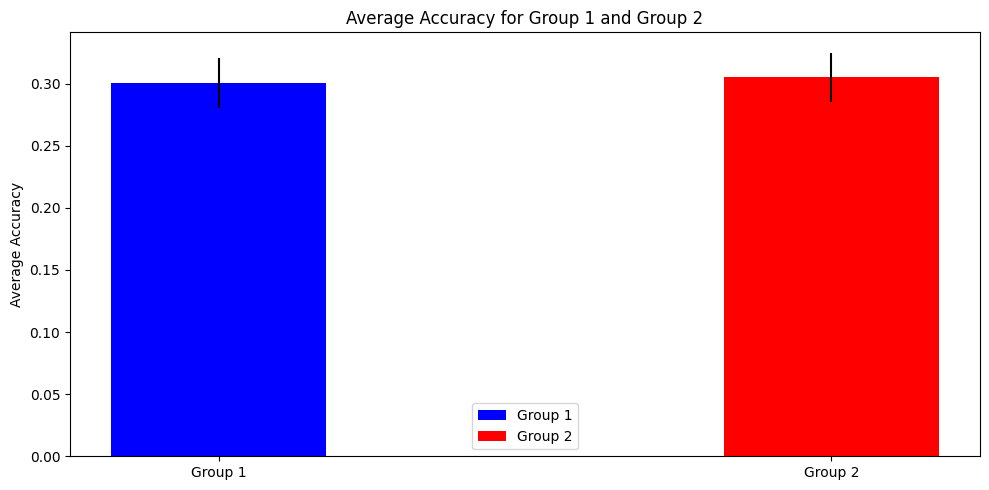

In [18]:
group_1 = ['c4 160M', 'c4 1.4B']
group_2 = [model for model in MODEL_ORDER if model not in group_1]

# Create dictionaries to store total accuracies and counts for each group
total_acc_group_1 = {'acc': 0, 'acc_stderr': 0}
total_acc_group_2 = {'acc': 0, 'acc_stderr': 0}
count_group_1 = 0
count_group_2 = 0

# Iterate over models in avg_acc_one_shot and avg_acc_few_shot
for model in avg_acc_one_shot:
    for param_size in avg_acc_one_shot[model]:
        # Check if the model is in group_1 or group_2
        if model + ' ' + param_size in group_1:
            total_acc_group_1['acc'] += avg_acc_one_shot[model][param_size][metric]
            total_acc_group_1['acc_stderr'] += avg_acc_one_shot[model][param_size][metric_std]**2
            count_group_1 += 1
        elif model + ' ' + param_size in group_2:
            total_acc_group_2['acc'] += avg_acc_one_shot[model][param_size][metric]
            total_acc_group_2['acc_stderr'] += avg_acc_one_shot[model][param_size][metric_std]**2
            count_group_2 += 1

# Calculate average accuracies and standard errors for each group
avg_acc_group_1 = {'acc': total_acc_group_1['acc'] / count_group_1, 'acc_stderr': (total_acc_group_1['acc_stderr'] / count_group_1)**0.5}
avg_acc_group_2 = {'acc': total_acc_group_2['acc'] / count_group_2, 'acc_stderr': (total_acc_group_2['acc_stderr'] / count_group_2)**0.5}

# Plot the results
plt.figure(figsize=(10, 5))

# Define the width of a bar
bar_width = 0.35

# Define the x locations for the groups
x = np.arange(2)

# Create the bars for group_1
plt.bar(x[0], avg_acc_group_1['acc'], width=bar_width, color='b', yerr=avg_acc_group_1['acc_stderr'])
# Create the bars for group_2
plt.bar(x[1], avg_acc_group_2['acc'], width=bar_width, color='r', yerr=avg_acc_group_2['acc_stderr'])

plt.xticks(x, ['Group 1', 'Group 2'])
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Group 1 and Group 2')
plt.legend(['Group 1', 'Group 2'])

plt.tight_layout()
plt.show()

In [ ]:
MODEL_ORDER

['c4 160M',
 'c4 1.4B',
 'c4 QA 160M',
 'c4 QA 1.4B',
 'c4 NLI 160M',
 'c4 NLI 1.4B',
 'c4 Summarization 160M',
 'c4 Summarization 1.4B',
 'c4 Commonsense 160M',
 'c4 Commonsense 1.4B']